# Rapport -- Weblogs opdracht -- Floris Buyse -- G2E2
---

#### !! Alle code gebruikt om de machine learningn modellen te trainen en te testen is te vinden onderaan deze file !!

## Data begrijpen en cleanen
---
1. Data opsplitsen (95 / 5)
2. ID droppen
3. NaN-waarden zoeken in data
4. NaN-waarden wegkrijgen / oplossen (4 verschillende manieren getest)
5. Feature importance bekijken
6. Conclusie
7. Verdere stappen
---

### 1. Data opsplitsen (95 / 5)
- We gebruiken 95% voor het trainen en testen van verschillende machine learning models en de andere 5% voor het finaal model en voor hertraining van dit finaal model
  
  ```python
  half = int(df.shape[0] * 0.95)
  df1 = df.iloc[:half]
  df2 = df.iloc[half:]

  df1.to_csv('../data/weblogs1.csv', index=False)
  df2.to_csv('../data/weblogs2.csv', index=False)
  ```
    deze code is ook terug te vinden in ``main_scripts/split_csv.ipynb``

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./data/weblogs1.csv')

### 2. ID droppen

- ``ID heeft geen toegevoegde waarde aan de data.``

In [4]:
df = df.drop(['ID'], axis=1)

### 3. NaN-waaren zoeken in data

- ``We zien dat "STANDARD_DEVIATION", "SF_FILETYPE" en "SF_REFERRER" NaN-waarden hebben``

In [5]:
X = df.drop(['ROBOT'], axis=1)
y = df['ROBOT']

In [6]:
X.isna().sum()[X.isna().sum() > 0]

STANDARD_DEVIATION    13520
SF_REFERRER           13520
SF_FILETYPE           13520
dtype: int64

### 4. NaN-waarden wegkrijgen / oplossen

#### 4.1 De features opvullen met 0

- We vullen de features op met nul en vergelijken de standaard deviatie (niet de feature) met die van de 'niet-opgevulde' X

In [7]:
X_zero = X.copy()
X_zero = X.fillna(0)
print(f"X met 0 opgevuld:\n------------------\n{X_zero[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}\n")
print(f"X zonder 0 opgevuld:\n---------------------\n{X[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")

X met 0 opgevuld:
------------------
STANDARD_DEVIATION    81.412416
SF_REFERRER            0.241471
SF_FILETYPE            0.270922
dtype: float64

X zonder 0 opgevuld:
---------------------
STANDARD_DEVIATION    89.781873
SF_REFERRER            0.243797
SF_FILETYPE            0.248241
dtype: float64


Bij STANDARD_DEVIATION zien we een redelijk groot verschil

---

#### 4.2 De features opvullen met mean

- We vullen de features op met mean() en vergelijken de standaard deviatie (niet de feature) met die van de 'niet-opgevulde' X

In [8]:
X_mean = X.copy()
X_mean = X.fillna(X.mean())
print(f"\nX met mean opgevuld:\n---------------------\n{X_mean[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")
print(f"\nX zonder mean opgevuld:\n------------------------\n{X[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")


X met mean opgevuld:
---------------------
STANDARD_DEVIATION    79.733879
SF_REFERRER            0.216512
SF_FILETYPE            0.220459
dtype: float64

X zonder mean opgevuld:
------------------------
STANDARD_DEVIATION    89.781873
SF_REFERRER            0.243797
SF_FILETYPE            0.248241
dtype: float64


Een nog groter verschil bij STANDARD_DEVIATION, maar deze keer ook een groter verschil bij de SF_FILETYPE EN SF_REFERRER

---

#### 4.3 De features opvullen met SimpleImputer met strategy 'mean'

- We vullen de features op met mean via de SimpleImputer en vergelijken de standaard deviatie (niet de feature) met die van de 'niet-opgevulde' X

In [9]:
from sklearn.impute import SimpleImputer

X_imputed = X.copy()

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_imputed)
X_imputed = pd.DataFrame(imputer.transform(X_imputed), columns=X_imputed.columns)

print(f"\nX met imputer opgevuld:\n------------------------\n{X_imputed[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")
print(f"\nX zonder imputer opgevuld:\n---------------------------\n{X[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")


X met imputer opgevuld:
------------------------
STANDARD_DEVIATION    79.733879
SF_REFERRER            0.216512
SF_FILETYPE            0.220459
dtype: float64

X zonder imputer opgevuld:
---------------------------
STANDARD_DEVIATION    89.781873
SF_REFERRER            0.243797
SF_FILETYPE            0.248241
dtype: float64


Er is geen verschil tussen het gebruik van 
```python 
X.fillna(X.mean())
``` 
en het gebruik van een 
```python
SimpleImputer(strategy="mean")
```

---

#### 4.4 De features met NaN-waarden droppen

- We droppen de features met NaN-waarden en testen ze uit op verschillende classificatiemodels

In [10]:
X_drop = X.copy()
X_drop = X.drop(['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE'], axis=1)

---

### 5. Feature importance bekijken

#### 5.1 Opsplitsen in train en test data

In [11]:
from sklearn.model_selection import train_test_split

X_zero_train, X_zero_test, y_train, y_test = train_test_split(X_zero, y, test_size=0.2, random_state=42)
X_mean_train, X_mean_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.2, random_state=42)
X_drop_train, X_drop_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2, random_state=42)

#### 5.2 DecisionTreeClassifier trainen op verschillende types data (X_zero, X_mean, X_drop)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def grid_test(type, X, y, cl_report):
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'max_depth': np.arange(2, 31)}, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    
    print(f"Decision Tree Classifier met {type}:\n------------------------------------")  

    print(grid_search.best_params_)

    y_pred = grid_search.predict(X)

    if cl_report:
        print(classification_report(y, y_pred))

    print(accuracy_score(y, y_pred))

    cm_mean = np.round(confusion_matrix(y, y_pred, normalize='true'), 2)

    print(cm_mean)
    print("------------------------------------")
    return grid_search.best_estimator_

#### 5.3 Feature Importance bekijken

Decision Tree Classifier met X_zero:
------------------------------------
{'max_depth': 15}
0.9864027975853245
[[0.99 0.01]
 [0.04 0.96]]
------------------------------------
Decision Tree Classifier met X_mean:
------------------------------------
{'max_depth': 15}
0.9862074354816652
[[0.99 0.01]
 [0.04 0.96]]
------------------------------------
Decision Tree Classifier met X_drop:
------------------------------------
{'max_depth': 16}
0.9873600718932541
[[0.99 0.01]
 [0.03 0.97]]
------------------------------------


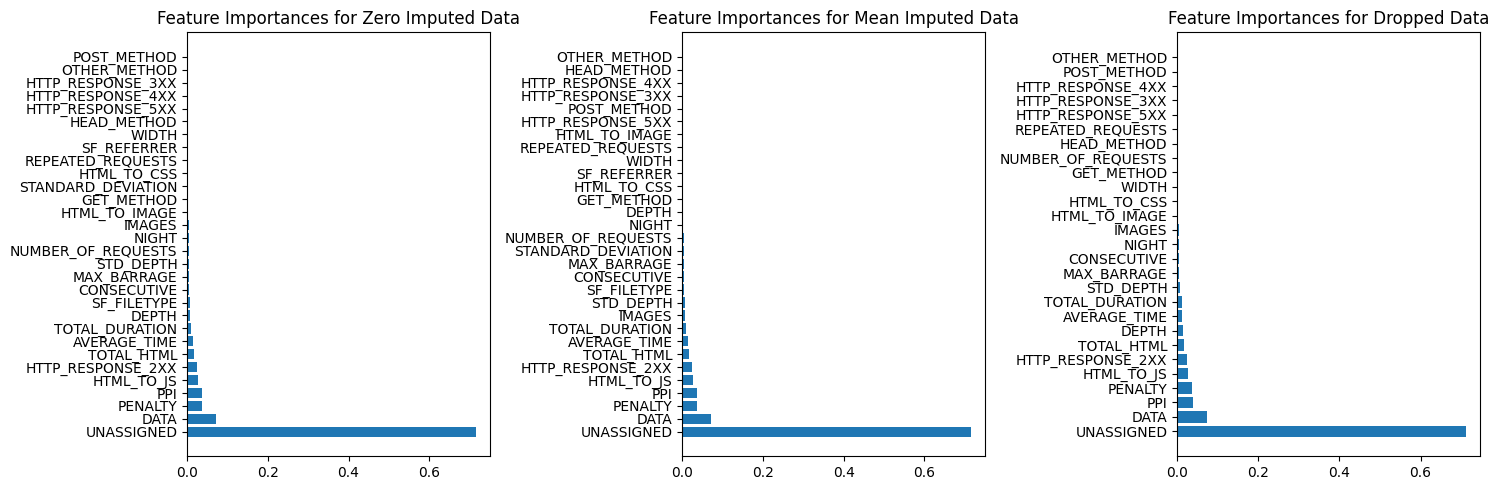

In [13]:
dt_clf_0 = grid_test("X_zero", X_zero_train, y_train, False)
dt_clf_0.fit(X_zero_train, y_train)

dt_clf_mean = grid_test("X_mean", X_mean_train, y_train, False)
dt_clf_mean.fit(X_mean_train, y_train)

dt_clf_drop = grid_test("X_drop", X_drop_train, y_train, False)
dt_clf_drop.fit(X_drop_train, y_train)

def feature_imp(clf, X):
    importances = clf.feature_importances_
    features = X.columns

    df_importances = pd.DataFrame({'feature': features, 'importance': importances})
    df_importances = df_importances.sort_values(by='importance', ascending=False)
    return df_importances

zero_importances = feature_imp(dt_clf_0, X_zero_train)
mean_importances = feature_imp(dt_clf_mean, X_mean_train)
drop_importances = feature_imp(dt_clf_drop, X_drop_train)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].barh(zero_importances['feature'], zero_importances['importance'])
ax[0].set_title('Feature Importances for Zero Imputed Data')

ax[1].barh(mean_importances['feature'], mean_importances['importance'])
ax[1].set_title('Feature Importances for Mean Imputed Data')

ax[2].barh(drop_importances['feature'], drop_importances['importance'])
ax[2].set_title('Feature Importances for Dropped Data')

plt.tight_layout()
plt.show()

Hier kunnen we duidelijk zien dat OTHER_METHOD, POST_METHOD, HEAD_METHOD, HTTP_RESPONSE(3,4,5)XX en REPEATED_REQUESTS geen importance hebben

#### 5.4 Features met weinig of geen importance droppen

In [14]:
X_zero = X.copy()
X_zero = X_zero.fillna(0)
X_zero = X_zero.drop(['OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

X_mean = X.copy()
X_mean = X_mean.fillna(X.mean())
X_mean = X_mean.drop(['OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

X_drop = X.copy()
X_drop = X.drop(['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

X_zero_train, X_zero_test, y_train, y_test = train_test_split(X_zero, y, test_size=0.2, random_state=42)
X_mean_train, X_mean_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.2, random_state=42)
X_drop_train, X_drop_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2, random_state=42)

#### 5.5 Opnieuw DecisionTreeClassifiers trainen en vergelijken met vorige

In [15]:
dt_clf_0 = grid_test("X_zero", X_zero_train, y_train, True)
dt_clf_0.fit(X_zero_train, y_train)

dt_clf_mean = grid_test("X_mean", X_mean_train, y_train, True)
dt_clf_mean.fit(X_mean_train, y_train)

dt_clf_drop = grid_test("X_drop", X_drop_train, y_train, True)
dt_clf_drop.fit(X_drop_train, y_train)

Decision Tree Classifier met X_zero:
------------------------------------
{'max_depth': 15}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     40990
           1       0.97      0.96      0.97     10197

    accuracy                           0.99     51187
   macro avg       0.98      0.98      0.98     51187
weighted avg       0.99      0.99      0.99     51187

0.9864027975853245
[[0.99 0.01]
 [0.04 0.96]]
------------------------------------
Decision Tree Classifier met X_mean:
------------------------------------
{'max_depth': 15}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     40990
           1       0.97      0.96      0.97     10197

    accuracy                           0.99     51187
   macro avg       0.98      0.98      0.98     51187
weighted avg       0.99      0.99      0.99     51187

0.9862074354816652
[[0.99 0.01]
 [0.04 0.96]]
---------------------------------

DecisionTreeClassifier(max_depth=15, random_state=42)

### 6. Conclusie

We zien geen grote verschillen tussen de verschillende DecisionTreeClassifiers. Het model getrained met de X_drop (waar de features met NaN-waarden gedropped zijn) heeft net iets betere resultaten dan de andere X'en (X_zero en X_mean). Na het droppen van de features met weinig importance was er een zeer lichte daling in recall en accuracy bij de DecisionTreeClassifier met X_drop.

### 7. Verdere stappen

- Nu ga ik aan de slag met de data, ik zal modellen trainen per soort (DecisionTree models & Andere soorten).
- Per onderdeel wordt er ook getest of scaling de resultaten verbeterd of niet
- Daarna zal ik tonen hoe goed (of slecht) het model het deed op de 5% achtergehouden data

## Imports, data inladen en opsplitsen

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, mean_squared_error, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./data/weblogs1.csv')

df = df.drop(['ID', 'STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)
X = df.drop(['ROBOT'], axis=1)
y = df['ROBOT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

(51187, 20) (12797, 20) (51187,) (12797,)


## DecisionTree Modellen
---

Alleen Scaling getest op DecisionTreeClassifier en heb het niet getest op de andere modellen omdat de resultaten verminderden.

1. DecisionTreeClassifier
2. BaggingClassifier zonder OOB
3. BaggingClassifier met OOB
4. AdaBoostClassifier
5. GradientBoostingClassifier
6. RandomForestClassifier
7. VotingClassifier
8. StackingClassifier

---

### 1. DecisionTreeClassifier

##### 1.0 Parameters

max_depth:

- Voordelen: voorkomen van overfitting en het bevorderen van generalisatie.
- Nadelen: Een te hoge waarde kan leiden tot overcomplicatie van het model, terwijl een te lage waarde kan resulteren in een te eenvoudige boom die mogelijk niet goed generaliseert.

min_samples_leaf:

- Voordelen: minimum aantal samples dat vereist is om een leafnode (heeft geen kinderen) te vormen. Het helpt overfitting te verminderen door ervoor te zorgen dat er genoeg samples in elk leafnode zijn om betrouwbare voorspellingen te doen.
- Nadelen: Een te hoge waarde kan leiden tot onderfitting, waarbij de boom te eenvoudig wordt en niet in staat is om complexe patronen in de gegevens vast te leggen.

min_samples_split:

- Voordelen: Bepaalt het minimum aantal samples dat vereist is om een interne node te splitsen tijdens het bouwen van de boom. Het helpt overfitting te voorkomen door te voorkomen dat nodes worden gesplitst als er te weinig monsters zijn.
- Nadelen: Een te hoge waarde kan leiden tot onderfitting, waarbij de boom te weinig splitsingen maakt en mogelijk niet goed genoeg leert van de gegevens.

##### 1.1 Zonder scaling
---

{'max_depth': 27, 'min_samples_leaf': 2, 'min_samples_split': 2}


0.9748378526217082


              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10337
           1       0.95      0.92      0.93      2460

    accuracy                           0.97     12797
   macro avg       0.97      0.95      0.96     12797
weighted avg       0.97      0.97      0.97     12797





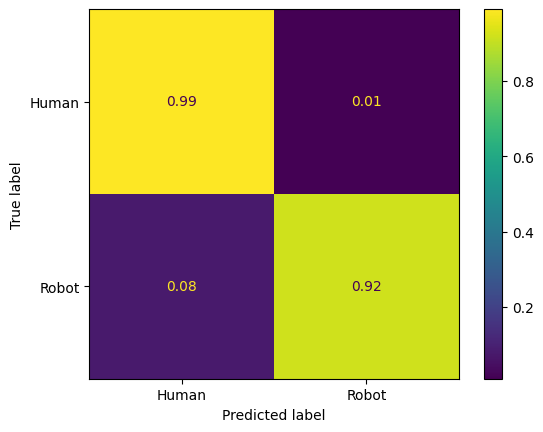

In [4]:
# duurt 5 minuten 16 seconden om te runnen (10 CPU-cores)

param_grid_dtc = {'max_depth': np.arange(15, 35), 'min_samples_split': np.arange(2, 20, 2), 'min_samples_leaf': np.arange(1, 10)}

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid_dtc, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_dtc.fit(X_train, y_train)

print(grid_search_dtc.best_params_)
print("\n")

dt_clf = grid_search_dtc.best_estimator_

dt_clf.fit(X_train, y_train)

y_pred_dtc = dt_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_dtc))
print("\n")
print(classification_report(y_test, y_pred_dtc))
print("\n")

cm = np.round(confusion_matrix(y_test, y_pred_dtc, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [8]:
filename = './main_models2/dt_clf.sav'
pickle.dump(dt_clf, open(filename, 'wb'))

##### 1.2 Met scaling
---

{'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 16}
0.9771040087520513

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.94      0.94      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.96      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



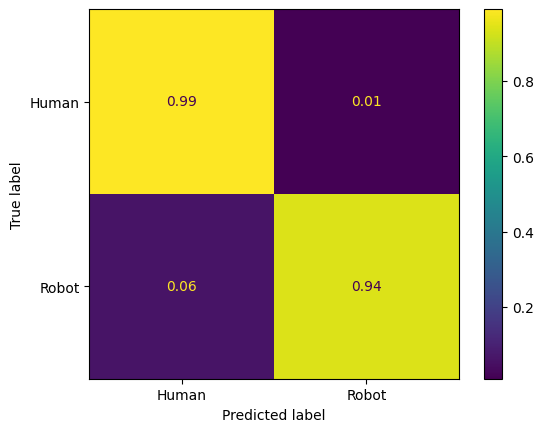

In [7]:
# duurt 5 minuten 9 seconden om te runnen (10 CPU-cores)

dt_clf_scaled = DecisionTreeClassifier(random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('gs_dt_clf_scaled', GridSearchCV(dt_clf_scaled, param_grid=param_grid_dtc, cv=5, n_jobs=-1, scoring='precision', return_train_score=True)),
])

pipeline.fit(X_train, y_train)

print(pipeline['gs_dt_clf_scaled'].best_params_)

dt_clf_scaled = pipeline['gs_dt_clf_scaled'].best_estimator_

dt_clf_scaled.fit(X_train, y_train)

y_pred_dtc_scaled = dt_clf_scaled.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_dtc_scaled)}\n")

print(classification_report(y_test, y_pred_dtc_scaled))

cm = np.round(confusion_matrix(y_test, y_pred_dtc_scaled, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [9]:
filename = './main_models2/dt_clf_scaled.sav'
pickle.dump(dt_clf_scaled, open(filename, 'wb'))

##### 1.3 Test op 5% achtergehouden data
---

**Niet gescaled**

---

76.28% Human | 23.72% Robot

Accuracy: 96.85%

Classification report:
```
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2531
           1       0.96      0.91      0.94       837
```

Confusion matrix:
```
[[0.99 0.01]
 [0.09 0.91]]
```

**Gescaled**

---

64.10% Human | 35.90% Robot

Accuracy: 86.76%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.84      0.90      2531
           1       0.66      0.96      0.78       837
```

Confusion matrix:
```
[[0.84 0.16]
 [0.04 0.96]]
```

##### 1.4 Conclusie

---

Scaling gaf betere test results, maar op de 5% achtergehouden data was het model zonder scaling beter.

### 2. BaggingClassifier zonder OOB

##### 2.0 Parameters

**n_estimators:**

- Voordelen: Verhoogt de diversiteit en robuustheid van de ensemble door meer base estimators toe te voegen.
- Nadelen: Kan leiden tot een langere trainingsduur en hoger geheugengebruik naarmate het aantal estimators toeneemt.

**max_samples:**

- Voordelen: Controleert het aantal samples dat wordt gebruikt om elke base estimator te trainen, waardoor de variabiliteit van de ensemble wordt vergroot.
- Nadelen: Een te laag aantal kan resulteren in een gebrek aan representativiteit van de gegevens, terwijl een te hoog aantal kan leiden tot redundantie en geen extra diversiteit biedt.

**bootstrap:**

- Voordelen: Stelt toe dat samples met vervanging worden gebruikt bij het trainen van elke base estimator, waardoor variabiliteit in de dataset wordt geïntroduceerd.
- Nadelen: Zonder vervanging (bootstrap=False) kunnen sommige samples worden gemist, wat de diversiteit van de ensemble kan verminderen.

**bootstrap_features:**

- Voordelen: Hiermee kunnen features met vervanging worden gebruikt bij het trainen van elke base estimator, wat kan helpen bij het introduceren van variabiliteit in de featureselectie.
- Nadelen: Zonder vervanging (bootstrap_features=False) kan het model beperkt zijn tot een specifieke subset van features, wat de diversiteit van de ensemble kan verminderen.

##### 2.1 Zonder scaling
---

{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 32000, 'n_estimators': 50}


0.9798390247714308


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.96      0.94      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.96      0.97     12797
weighted avg       0.98      0.98      0.98     12797



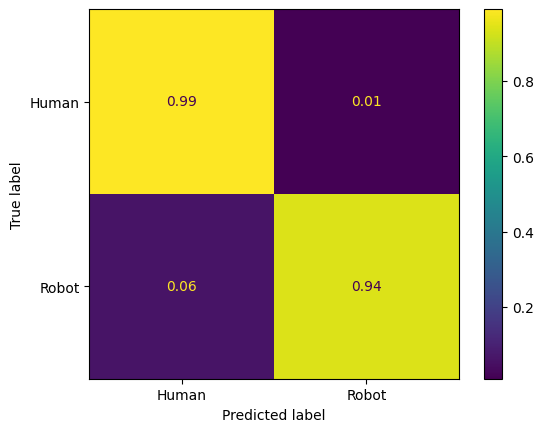

In [10]:
param_grid_bag = {'n_estimators': [30, 40, 50, 60], 'max_samples': [30000, 31000, 32000, 33000, 34000, 35000], 'bootstrap': [True, False], 'bootstrap_features': [True, False]}

grid_search_bag = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42), param_grid=param_grid_bag, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_bag.fit(X_train, y_train)

print(grid_search_bag.best_params_)
print("\n")

bag_clf = grid_search_bag.best_estimator_

bag_clf.fit(X_train, y_train)

y_pred_bc = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_bc))
print("\n")
print(classification_report(y_test, y_pred_bc))

cm = np.round(confusion_matrix(y_test, y_pred_bc, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### 2.2 Test op 5% achtergehouden data

75.98% Human | 24.02% Robot

Accuracy: 97.15%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2531
           1       0.96      0.93      0.94       837
```

Confusion matrix:
```
[[0.99 0.01]
 [0.07 0.93]]
```

In [12]:
filename = './main_models2/bag_clf.sav'
pickle.dump(bag_clf, open(filename, 'wb'))

### 3. BaggingClassifier met OOB

##### 3.0 Parameters

**OOB_score:**

- Voordelen: OOB-score biedt een schatting van de prestaties van het ensemble op ongeziene gegevens zonder dat er een aparte validatieset nodig is.
- Nadelen: OOB-score is een schatting en kan minder betrouwbaar zijn dan een aparte validatieset.

##### 3.1 Zonder scaling
---

{'max_samples': 17000, 'n_estimators': 36}


0.9783343427042023


0.9799953114011096


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.95      0.95      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.97      0.97     12797
weighted avg       0.98      0.98      0.98     12797



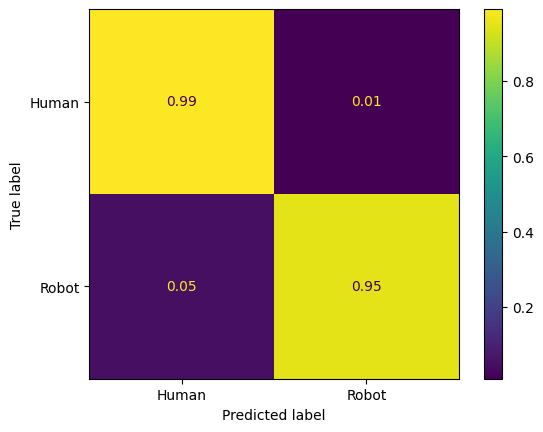

In [11]:
# 2 minuten om te runnen (10 CPU-cores)

param_grid_bag_oob = {'n_estimators': np.arange(30, 46, 2), 'max_samples': [13000, 14000, 15000, 16000, 17000, 18000]}

grid_search_bag_oob = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42, oob_score=True), param_grid=param_grid_bag_oob, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_bag_oob.fit(X_train, y_train)

print(grid_search_bag_oob.best_params_)
print("\n")

bag_clf_oob = grid_search_bag_oob.best_estimator_

bag_clf_oob.fit(X_train, y_train)

print(bag_clf_oob.oob_score_)

y_pred_oob = bag_clf_oob.predict(X_test)

print('\n')
print(accuracy_score(y_test, y_pred_oob))
print("\n")
print(classification_report(y_test, y_pred_oob))

cm = np.round(confusion_matrix(y_test, y_pred_oob, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [13]:
filename = './main_models2/bag_clf_oob.sav'
pickle.dump(bag_clf_oob, open(filename, 'wb'))

##### 3.3 Test op 5% achtergehouden data
---

75.65% Human | 24.35% Robot

Accuracy: 97.00%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2531
           1       0.95      0.93      0.94       837
```

Confusion matrix:

```
[[0.98 0.02]
 [0.07 0.93]]
```

### 4. AdaBoostClassifier

##### 4.0 Parameters

**algorithm:**

- SAMME:
    - Voordelen: Werkt goed voor klassen met een discreet en eindig aantal uitkomsten.
    - Nadelen: Kan slecht presteren als er een groot aantal klassen zijn of als de classificatieproblemen complex zijn.
- SAMME.R:
    - Voordelen: Gebruikt class probabilities in plaats van binaire voorspellingen, wat kan leiden tot betere prestaties.
    - Nadelen: Kan meer rekenkracht en geheugen vereisen in vergelijking met SAMME.

**learning_rate:**

- Voordelen: Het biedt controle over de bijdrage van elke classifier, waardoor fijnafstemming van de ensemble-output mogelijk is.
- Nadelen: Een te hoge learning_rate kan overfitting veroorzaken als het niet goed wordt afgestemd.

**n_estimators:**

- Voordelen: Een hoger aantal estimators kan de flexibiliteit en prestaties van het ensemble verbeteren.
- Nadelen: Een te hoog aantal estimators kan de trainingsduur verlengen en overfitting veroorzaken als het niet nodig is.

##### 4.1 Zonder scaling
---

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 2}


0.9756192857701024

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10337
           1       0.96      0.91      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.95      0.96     12797
weighted avg       0.98      0.98      0.98     12797



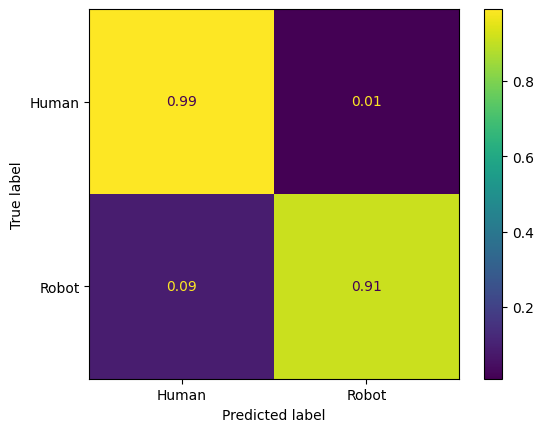

In [4]:
# 7 minuten en 9 seconden om te runnen (10 CPU-cores)

grid_search_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), param_grid={'n_estimators': np.arange(1, 30), 'learning_rate': [0.1, 0.5, 1, 2], 'algorithm': ['SAMME.R']}, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_ada.fit(X_train, y_train)

print(grid_search_ada.best_params_)
print("\n")

ada_clf = grid_search_ada.best_estimator_
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred_ada)}\n")

print(classification_report(y_test, y_pred_ada))

cm = np.round(confusion_matrix(y_test, y_pred_ada, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [8]:
filename = './main_models2/ada_clf.sav'
pickle.dump(ada_clf, open(filename, 'wb'))

##### 4.2 Test op 5% achtergehouden data
---

76.78% Human | 23.22% Robot

Accuracy: 96.47%

Classification report:
```
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2531
           1       0.96      0.90      0.93       837
```

Confusion matrix:
```
[[0.99 0.01]
 [0.1  0.9 ]]
```

### 5. GradientBoostingClassifier

##### 5.0 Parameters

**n_estimators:**

- Voordelen: Een groter aantal boosting stages kan leiden tot betere prestaties en een hogere nauwkeurigheid van het model. Het kan ook robuust zijn tegen overfitting.
- Nadelen: Een te groot aantal boosting stages kan de trainingsduur verlengen.

**learning_rate:**

- Voordelen: Door de bijdrage van elke boom te verkleinen met de learning_rate, kan het model meer geleidelijk leren en de impact van individuele bomen verminderen. Dit kan helpen bij het reguleren van het leerproces en overfitting voorkomen.
- Nadelen: Een te kleine learning_rate kan leiden tot langzamer leren en mogelijk vereisen dat er meer boosting stages nodig zijn om de gewenste prestaties te bereiken.

**max_depth:**

- Voordelen: Het beperken van de maximale diepte van de knopen in de boom kan helpen bij het voorkomen van overfitting en het reguleren van de complexiteit van het model.
- Nadelen: Een te beperkte max_depth kan resulteren in onderfitting, waarbij het model niet voldoende complexiteit heeft om de gegevens goed te modelleren.

##### 5.1 Zonder scaling
---

{'learning_rate': 1, 'max_depth': 17, 'n_estimators': 220}


Best n_esimators: 146

0.9803078846604673

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.96      0.94      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.97      0.97     12797
weighted avg       0.98      0.98      0.98     12797



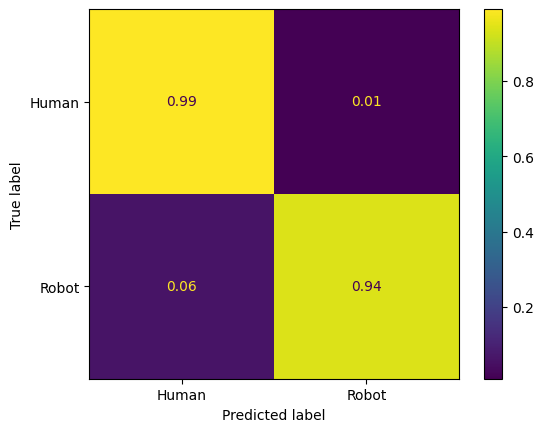

In [5]:
# 156 minuten en 37 seconden om te runnen (10 CPU-cores)

param_grid_gradient = {'n_estimators': [190, 200, 210, 220], 'learning_rate': [0.1, 0.5, 1, 2], 'max_depth': np.arange(1, 20) }

grid_search_gradient = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=param_grid_gradient, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_gradient.fit(X_train, y_train)

print(grid_search_gradient.best_params_)
print("\n")

gbrt = grid_search_gradient.best_estimator_
gbrt.fit(X_train, y_train)

errors_gbrt = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]

best_n_estimators = np.argmin(errors_gbrt) + 1
print(f"Best n_esimators: {best_n_estimators}\n")

gbrt_best = GradientBoostingClassifier(random_state=42, n_estimators=best_n_estimators, learning_rate=grid_search_gradient.best_params_['learning_rate'], max_depth=grid_search_gradient.best_params_['max_depth'])
gbrt_best.fit(X_train, y_train)

y_pred_gbrt = gbrt_best.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_gbrt)}\n")

print(classification_report(y_test, y_pred_gbrt))

cm = np.round(confusion_matrix(y_test, y_pred_gbrt, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [9]:
filename2 = './main_models2/gbrt_best.sav'
pickle.dump(gbrt_best, open(filename2, 'wb'))

##### 5.2 Test op 5% achtergehouden data
---

76.07% Human | 23.93% Robot

Accuracy: 97.36%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2531
           1       0.96      0.93      0.95       837
```


Confusion matrix:
```
[[0.99 0.01]
 [0.07 0.93]]
```

### 6. RandomForestClassifier

##### 6.0 Parameters

**n_estimators:**

- Voordelen: Een groter aantal estimators kan resulteren in een betere stabiliteit en robuustheid van het model, omdat het de variabiliteit in de ensemble verhoogt. Het kan ook de nauwkeurigheid van het model verbeteren.
- Nadelen: Een te groot aantal estimators kan de trainings- en inferentietijd verlengen.

**max_depth:**

- Voordelen: Het beperken van de maximale diepte van de bomen kan overfitting helpen voorkomen en de complexiteit van het model reguleren. Het kan ook zorgen voor een betere generalisatie van het model.
- Nadelen: Een te beperkte max_depth kan resulteren in onderfitting, waarbij het model niet voldoende complexiteit heeft om de gegevens goed te modelleren.

**min_samples_leaf:**

- Voordelen: Het instellen van een minimum aantal samples vereist in een blad van de boom kan helpen bij het reguleren van de groei van de bomen en overfitting voorkomen. Het kan ook de interpretatie van het model vergemakkelijken door de resulterende bomen eenvoudiger te maken.
- Nadelen: Een te groot minimum aantal samples vereist in een blad kan leiden tot onderfitting, waarbij het model niet genoeg gedetailleerde beslissingsgrenzen kan leren.

**min_samples_split:**

- Voordelen: Het instellen van een minimum aantal samples vereist om een knoop te splitsen kan helpen bij het reguleren van de groei van de bomen en overfitting voorkomen. Het kan ook de interpretatie van het model vergemakkelijken door de resulterende bomen eenvoudiger te maken.
- Nadelen: Een te groot minimum aantal samples vereist om een knoop te splitsen kan leiden tot onderfitting, waarbij het model niet genoeg gedetailleerde beslissingsgrenzen kan leren.

**bootstrap [True, False]:**

- bootstrap=True:
    - Voordelen: Het gebruik van bootstrap-samples (met vervanging) kan de variabiliteit in de dataset verhogen, wat resulteert in diverse bomen in het ensemble. Dit kan de prestaties van het model verbeteren en het robuuster maken voor variaties in de gegevens.
    - Nadelen: Het kan de trainings- en inferentietijd verlengen, omdat elke boom wordt getraind op een subset van de gegevens.


- bootstrap=False:
  - Voordelen: Het niet gebruiken van bootstrap-samples betekent dat elke boom wordt getraind op de volledige trainingsset zonder vervanging. Hierdoor kunnen de resulterende bomen lager gecorreleerd zijn en minder overfitting vertonen.
  - Nadelen: Het kan de variabiliteit in de dataset verminderen, wat kan resulteren in minder diverse bomen en mogelijk een verminderde robuustheid van het model. Het kan ook de gevoeligheid voor ruis in de gegevens vergroten.

##### 6.1 Zonder scaling
---

{'bootstrap': False, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 140}
0.9801515980307884

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.95      0.95      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.97      0.97     12797
weighted avg       0.98      0.98      0.98     12797



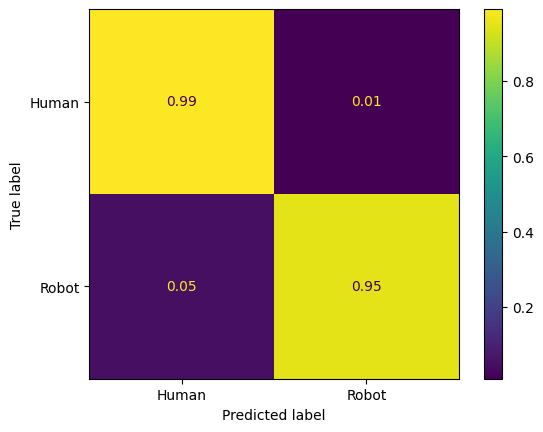

In [7]:
# 37 minuten en 3 seconden om te runnen (10 CPU-cores)

param_grid_rfc = {
    'n_estimators': np.arange(100, 160, 10),
    'max_depth': [15, 20, 25, 30, 35],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 5, 10],
    'bootstrap' : [True, False],
}

grid_search_rfc = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid_rfc, cv=5, n_jobs=-1)

grid_search_rfc.fit(X_train, y_train)

print(grid_search_rfc.best_params_)

rf_clf = grid_search_rfc.best_estimator_
rf_clf.fit(X_train, y_train)

y_pred_rfc = rf_clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred_rfc)}\n")

print(classification_report(y_test, y_pred_rfc))

cm = np.round(confusion_matrix(y_test, y_pred_rfc, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [10]:
filename3 = './main_models2/rf_clf.sav'
pickle.dump(rf_clf, open(filename3, 'wb'))

##### 6.2 Test op 5% achtergehouden data
---

75.21% Human | 24.79% Robot

Accuracy: 97.21%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2531
           1       0.94      0.94      0.94       837
```

Confusion matrix:
```
 [[0.98 0.02]
 [0.06 0.94]]
``` 

### 7. VotingClassifier

##### 7.0 Parameters

---

**weights:**
gewichten toe kennen aan individuele modellen in het ensemble. Hierdoor kun je de invloed van elk model op de uiteindelijke voorspellingen reguleren.

- Voordelen: Het instellen van gewichten voor de individuele modellen kan de invloed van elk model op de voorspellingen van het ensemble reguleren. Dit kan de prestaties van het ensemble verbeteren.
- Nadelen: Het instellen van gewichten voor de individuele modellen kan de interpretatie van het ensemble moeilijker maken.

##### 7.1 Zonder scaling (Soft voting)

---

{'weights': [1, 1, 1, 2, 2]}


0.9803078846604673

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.95      0.94      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.97      0.97     12797
weighted avg       0.98      0.98      0.98     12797



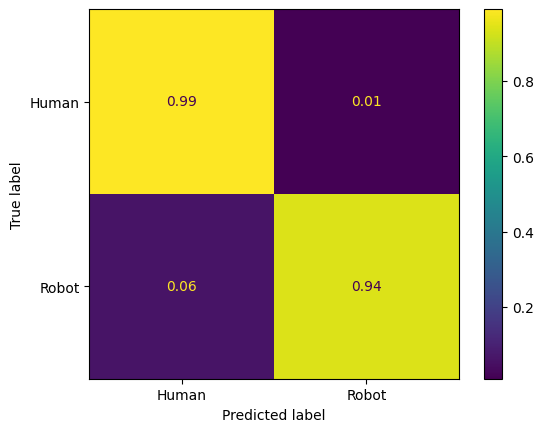

In [11]:
# 7 minuten 7 seconden om te runnen (10 CPU-cores)

bag_clf_oob = BaggingClassifier(DecisionTreeClassifier(random_state=42), max_samples=17000, n_estimators=36, bootstrap=True, oob_score=True, random_state=42)
bag_clf_oob.fit(X_train, y_train)

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), max_samples=32000, n_estimators=50, bootstrap=True, random_state=42)

param_grid_voting = {
    'weights': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 2], [1, 1, 1, 2, 2], [1, 1, 2, 2, 2], [1, 2, 2, 2, 2], [2, 2, 2, 2, 2]],
}

grid_search_voting = GridSearchCV(VotingClassifier(
    estimators=[('rf', rf_clf), ('gbrt', gbrt_best), ('ada', ada_clf), ('bag_oob', bag_clf_oob), ('bag', bag_clf)], 
    voting='soft'), 
    param_grid=param_grid_voting, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_voting.fit(X_train, y_train)

print(grid_search_voting.best_params_)
print("\n")

voting_clf = grid_search_voting.best_estimator_

voting_clf.fit(X_train, y_train)

y_pred_voting = voting_clf.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_voting)}\n")

print(classification_report(y_test, y_pred_voting))

cm = np.round(confusion_matrix(y_test, y_pred_voting, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [14]:
filename5 = './main_models2/voting_clf.sav'
pickle.dump(voting_clf, open(filename5, 'wb'))

##### 7.2 Zonder scaling (Hard voting)

---

{'weights': [1, 1, 2, 2, 2]}


0.9802297413456279

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.95      0.94      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.97      0.97     12797
weighted avg       0.98      0.98      0.98     12797



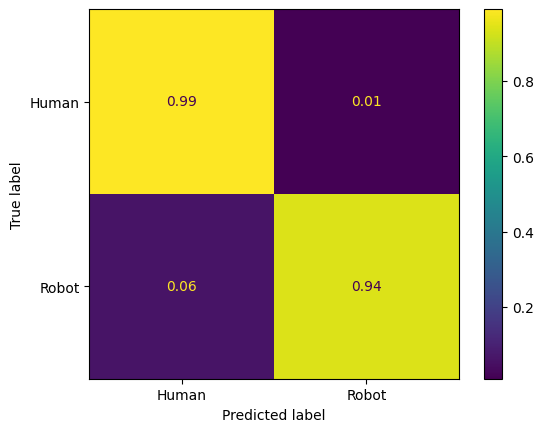

In [12]:
# 6 minuten 55 seconden om te runnen (10 CPU-cores)

bag_clf_oob = BaggingClassifier(DecisionTreeClassifier(random_state=42), max_samples=17000, n_estimators=36, bootstrap=True, oob_score=True, random_state=42)
bag_clf_oob.fit(X_train, y_train)

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), max_samples=32000, n_estimators=50, bootstrap=True, random_state=42)

param_grid_voting = {
    'weights': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 2], [1, 1, 1, 2, 2], [1, 1, 2, 2, 2], [1, 2, 2, 2, 2], [2, 2, 2, 2, 2]],
}

grid_search_voting_hard = GridSearchCV(VotingClassifier(
    estimators=[('rf', rf_clf), ('gbrt', gbrt_best), ('ada', ada_clf), ('bag_oob', bag_clf_oob), ('bag', bag_clf)], 
    voting='hard'), 
    param_grid=param_grid_voting, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_voting_hard.fit(X_train, y_train)

print(grid_search_voting_hard.best_params_)
print("\n")

voting_clf_hard = grid_search_voting_hard.best_estimator_

voting_clf_hard.fit(X_train, y_train)

y_pred_voting_hard = voting_clf_hard.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_voting_hard)}\n")

print(classification_report(y_test, y_pred_voting_hard))

cm = np.round(confusion_matrix(y_test, y_pred_voting_hard, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [13]:
filename4 = './main_models2/voting_clf_hard.sav'
pickle.dump(voting_clf_hard, open(filename4, 'wb'))

##### 7.3 Test op 5% achtergehouden data

---

**Soft voting**

75.80% Human | 24.20% Robot

Accuracy: 97.27%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2531
           1       0.96      0.93      0.94       837
```

Confusion matrix:
```
[[0.99 0.01]
 [0.07 0.93]]
```

**Hard voting**

75.92% Human | 24.08% Robot

Accuracy: 97.27%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2531
           1       0.96      0.93      0.94       837
```

Confusion matrix:
```
[[0.99 0.01]
 [0.07 0.93]]
```

### 8.0 StackingClassifier

##### 8.1 Zonder scaling (RandomForest als final estimator)

---

0.976869578807533

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10337
           1       0.95      0.93      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



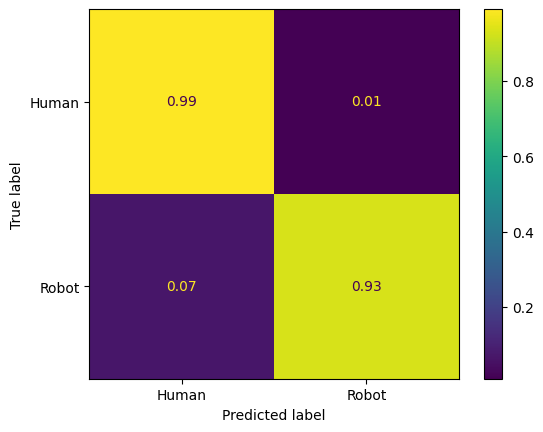

In [8]:
# duur 2 minuten en 58 seconden om te runnen (10 CPU-cores)

rf_clf = RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=140, random_state=42)
rf_clf.fit(X_train, y_train)

gbrt_best = GradientBoostingClassifier(max_depth=17, n_estimators=146, learning_rate=1, random_state=42)
gbrt_best.fit(X_train, y_train)

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=2, algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

bag_clf_oob = BaggingClassifier(DecisionTreeClassifier(random_state=42), max_samples=17000, n_estimators=36, bootstrap=True, oob_score=True, random_state=42)
bag_clf_oob.fit(X_train, y_train)

estimators = [('rf', rf_clf), ('gbrt', gbrt_best), ('ada', ada_clf), ('bag_oob', bag_clf_oob)]

stacking_clf_1 = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=42), cv=5, n_jobs=-1)
stacking_clf_1.fit(X_train, y_train)

y_pred_stacking = stacking_clf_1.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_stacking)}\n")

print(classification_report(y_test, y_pred_stacking))

cm = np.round(confusion_matrix(y_test, y_pred_stacking, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [9]:
filename = './main_models/stacking_clf_rfc_final.sav'
pickle.dump(stacking_clf_1, open(filename, 'wb'))

##### 8.2 Zonder scaling (GradientBoostingClassifier als final estimator)

---

0.9802297413456279

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.95      0.94      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.97      0.97     12797
weighted avg       0.98      0.98      0.98     12797



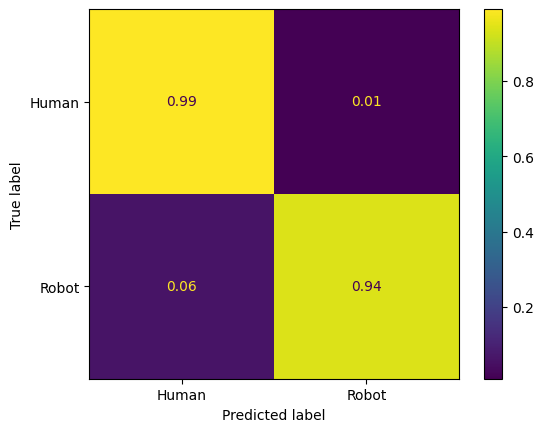

In [5]:
# 3 minuten en 3 seconden om te runnen (10 CPU-cores)

rf_clf = RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=140, random_state=42)
rf_clf.fit(X_train, y_train)

gbrt_best = GradientBoostingClassifier(max_depth=17, n_estimators=146, learning_rate=1, random_state=42)
gbrt_best.fit(X_train, y_train)

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=2, algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

bag_clf_oob = BaggingClassifier(DecisionTreeClassifier(random_state=42), max_samples=17000, n_estimators=36, bootstrap=True, oob_score=True, random_state=42)
bag_clf_oob.fit(X_train, y_train)

estimators = [('rf', rf_clf), ('gbrt', gbrt_best), ('ada', ada_clf), ('bag_oob', bag_clf_oob)]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(random_state=42), cv=5, n_jobs=-1)
stacking_clf.fit(X_train, y_train)

y_pred_stacking = stacking_clf.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_stacking)}\n")

print(classification_report(y_test, y_pred_stacking))

cm = np.round(confusion_matrix(y_test, y_pred_stacking, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [7]:
filename = './main_models/stacking_clf_grad_boost_final.sav'
pickle.dump(stacking_clf, open(filename, 'wb'))

##### 8.3 Test op 5% achtergehouden data

---

**RandomForest als final estimator**

75.45% Human | 24.55% Robot

Accuracy: 96.79%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2531
           1       0.94      0.93      0.94       837

    accuracy                           0.97      3368
   macro avg       0.96      0.96      0.96      3368
weighted avg       0.97      0.97      0.97      3368
```

Confusion matrix:
```
[[0.98 0.02]
 [0.07 0.93]]
```

**GradientBoostingClassifier als final estimator**

75.50% Human | 24.50% Robot

Accuracy: 97.21%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2531
           1       0.95      0.94      0.94       837

    accuracy                           0.97      3368
   macro avg       0.96      0.96      0.96      3368
weighted avg       0.97      0.97      0.97      3368
```

Confusion matrix:
```
[[0.98 0.02]
 [0.06 0.94]]
```

## Andere models

---

1. KNeighbourClassifier
2. LogisticRegression
3. LinearSVC

---

### 1. KNeighbourClassifier

##### 1.1 Parameters

---

**n_neighbors: (Grootte van de lokale 'buurt')**

- Voordelen: Vastleggen van complexe patronen, verbetering van nauwkeurigheid.
- Nadelen: Toegenomen berekeningscomplexiteit, mogelijk oversmoothing (minder gedetailleerde resultaten).

**weights: ['uniform', 'distance']: (Bijdrage van elke buur)**

- uniform:
    - Voordelen: Gelijke bijdrage van alle buren.
    - Nadelen: Geen rekening houden met relevantie van buren, suboptimale prestaties wanneer sommige buren meer relevant zijn dan andere.

- distance:
  - Voordelen: Hogere belangrijkheid voor nabije buren, effectief bij het vastleggen van lokale patronen.
  - Nadelen: Verhoogde berekeningskosten en complexiteit.

**metric: ['euclidean', 'manhattan']: (Afstandsmaat om de afstand tussen gegevenspunten te berekenen)**

- euclidean:
    - Voordelen: Geschikt voor datasets met lage dimensionaliteit en gelijkmatig geschaalde kenmerken.
    - Nadelen: Niet optimaal voor datasets met gemengde datatypes of afwijkende schalen.
- manhattan:
    - Voordelen: Geschikt voor datasets met hoge dimensionaliteit of kenmerken met verschillende schalen.
    - Nadelen: Kan minder geschikt zijn voor andere datatypes of wanneer de schaalvariatie groot is.

**algorithm: ['auto', 'ball_tree', 'kd_tree']: (Algoritme om de dichtstbijzijnde buren te vinden)**

- auto:
    - Voordelen: Automatische selectie van het meest geschikte algoritme op basis van de gegevens.
    - Nadelen: Kan in sommige gevallen niet de meest efficiënte keuze zijn.
- ball_tree:
    - Voordelen: Efficiënt bij lage dimensionaliteit van de gegevens.
    - Nadelen: Hogere kosten bij grote datasets.
- kd_tree:
    - Voordelen: Efficiënt bij hoge dimensionaliteit van de gegevens.
    - Nadelen: Hogere kosten bij grote datasets.

##### 1.2 Met scaling

---

{'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}

Accuracy: 92.33%


              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10337
           1       0.89      0.68      0.77      2460

    accuracy                           0.92     12797
   macro avg       0.91      0.83      0.86     12797
weighted avg       0.92      0.92      0.92     12797



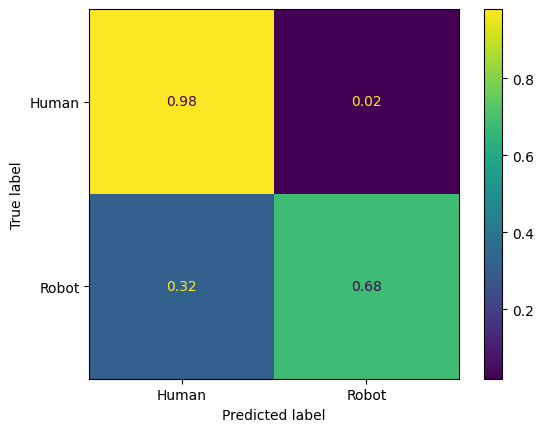

In [19]:
# duurt 10 minuten en 51 seconden om te runnen (10 CPU-cores)

param_grid_knn_scaled = {
    'n_neighbors': np.arange(1, 10),
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('grid_search', GridSearchCV(param_grid=param_grid_knn_scaled, estimator=KNeighborsClassifier(), cv=5, n_jobs=-1, scoring='precision'))
])

pipeline.fit(X_train, y_train)

print(pipeline['grid_search'].best_params_)

knn_clf_scaled = pipeline['grid_search'].best_estimator_

knn_clf_scaled.fit(X_train, y_train)

y_pred_knn_scaled = knn_clf_scaled.predict(X_test)

print("\nAccuracy: {:.2f}".format(((accuracy_score(y_test, y_pred_knn_scaled)) * 100)) + "%")
print("\n")
print(classification_report(y_test, y_pred_knn_scaled))

cmDiplay = ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, y_pred_knn_scaled, normalize='true'), 2), display_labels=['Human', 'Robot'])
cmDiplay.plot()

In [24]:
filename6 = './main_models2/knn_clf_scaled.sav'
pickle.dump(knn_clf_scaled, open(filename6, 'wb'))

##### 1.3 Zonder scaling

---

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}



Accuracy: 92.26%


              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10337
           1       0.89      0.68      0.77      2460

    accuracy                           0.92     12797
   macro avg       0.91      0.83      0.86     12797
weighted avg       0.92      0.92      0.92     12797



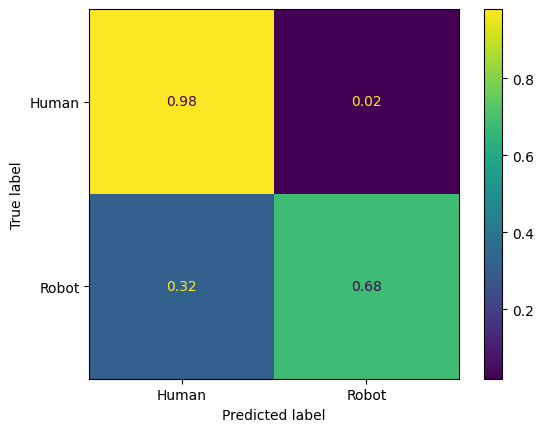

In [20]:
# duurt 2 minuten om te runnen (10 CPU-cores)

grid_search_knn_no_scale = GridSearchCV(param_grid=param_grid_knn_scaled, estimator=KNeighborsClassifier(), cv=5, n_jobs=-1, verbose=2, scoring='precision')

grid_search_knn_no_scale.fit(X_train, y_train)

print(grid_search_knn_no_scale.best_params_)
print("\n")

knn_clf_no_scale = grid_search_knn_no_scale.best_estimator_

knn_clf_no_scale.fit(X_train, y_train)

y_pred_knn_no_scale = knn_clf_no_scale.predict(X_test)

print("\nAccuracy: {:.2f}".format(((accuracy_score(y_test, y_pred_knn_no_scale)) * 100)) + "%")
print("\n")
print(classification_report(y_test, y_pred_knn_no_scale))

cmDiplay = ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, y_pred_knn_no_scale, normalize='true'), 2), display_labels=['Human', 'Robot'])
cmDiplay.plot()

In [23]:
filename7 = './main_models2/knn_clf_no_scale.sav'
pickle.dump(knn_clf_no_scale, open(filename7, 'wb'))

##### 1.4 Test op 5% achtergehouden data

**Niet gescaled**

80.46% Human | 19.54% Robot

Accuracy: 88.45%

Classification report:
```
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      2531
           1       0.84      0.66      0.74       837
```

Confusion matrix:
```
[[0.96 0.04]
 [0.34 0.66]]
```

**Gescaled**

100.00% Human | 0.00% Robot

Accuracy: 75.15%

Classification report:
```
               precision    recall  f1-score   support

           0       0.75      1.00      0.86      2531
           1       0.00      0.00      0.00       837
```

Confusion matrix:
```
[[1. 0.]
 [1. 0.]]
```

### 2. LogisticRegression

##### 2.1 Parameters

---

**C:**

- Voordelen: Regelt mate van regulatie in model. Hogere waarden van "C" leiden tot minder regulatie en stellen het model in staat om meer complexe beslissingsgrenzen te leren. Lagere waarden van "C" bevorderen meer regulatie en kunnen helpen overfitting te verminderen.

- Nadelen: Het kiezen van een verkeerde waarde voor "C" kan leiden tot suboptimale prestaties. Een te hoge waarde kan overfitting veroorzaken, terwijl een te lage waarde kan leiden tot underfitting.

**solver:**

- 'newton-cg':
    - Voordelen: Efficiënt bij datasets met zowel kleine als grote aantallen datapunten. Werkt goed voor multiklasse-classificatieproblemen.
    - Nadelen: Vereist dat de gegevens matrixvormig zijn en kan minder effectief zijn bij grote datasets met veel functies.

- 'lbfgs':
    - Voordelen: Werkt goed voor kleine tot middelgrote datasets en is relatief robuust tegen overfitting.
    - Nadelen: Kan trager zijn dan andere solvers bij grote datasets.

- 'liblinear':
    - Voordelen: Efficiënt bij datasets met veel functies en biedt ondersteuning voor zowel reguliere als ongereguleerde modellen.
    - Nadelen: Kan minder geschikt zijn voor multiklasse-classificatieproblemen.

- 'sag':
    - Voordelen: Efficiënt bij grote datasets en kan sneller convergeren dan andere solvers.
    - Nadelen: Vereist dat de verliesfunctie differentieerbaar is en kan minder stabiel zijn bij problemen met sterke regularisatie.

- 'saga':
  - Voordelen: Geschikt voor grote datasets en biedt ondersteuning voor zowel reguliere als ongereguleerde modellen. Kan goed presteren bij problemen met sterke regularisatie.
  - Nadelen: Kan trager zijn dan andere solvers bij grote datasets en vereist dat de verliesfunctie differentieerbaar is.

**penalty:**

- 'l1':
    - Voordelen: Geschikt voor schattingen met veel nulwaarden en helpt bij het selecteren van relevante functies.
    - Nadelen: Kan minder stabiel zijn bij datasets met hoge dimensionaliteit.

- 'l2':
    - Voordelen: Werkt goed voor reguliere modellen en biedt stabiliteit bij het trainen van het model.
    - Nadelen: Minder geschikt voor schattingen met veel nulwaarden.

- 'elasticnet':
    - Voordelen: Biedt een combinatie van 'l1' en 'l2' penalty's, waardoor zowel schattingen met veel nulwaarden als reguliere modellen kunnen worden behandeld.
    - Nadelen: Kan complexer zijn om te optimaliseren en vereist afstemming van de elasticiteitsparameter.

- 'none':
    - Voordelen: Geen penalty toegepast, wat nuttig kan zijn bij het omgaan met al geregulariseerde gegevens.
    - Nadelen: Kan leiden tot overfitting bij modellen met hoge dimensionaliteit of weinig gegevens.

**max_iter:**

- Voordelen: Bepaalt het maximum aantal iteraties voor het convergeren van het model, wat kan helpen bij het regelen van de looptijd.
- Nadelen: Een te lage waarde kan leiden tot een onvolledige optimalisatie en een te hoge waarde kan leiden tot langere trainingsduur.

##### 2.2 Met scaling

---

{'C': 20, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}



Accuracy: 84.55%
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     10337
           1       0.81      0.26      0.39      2460

    accuracy                           0.85     12797
   macro avg       0.83      0.62      0.65     12797
weighted avg       0.84      0.85      0.81     12797





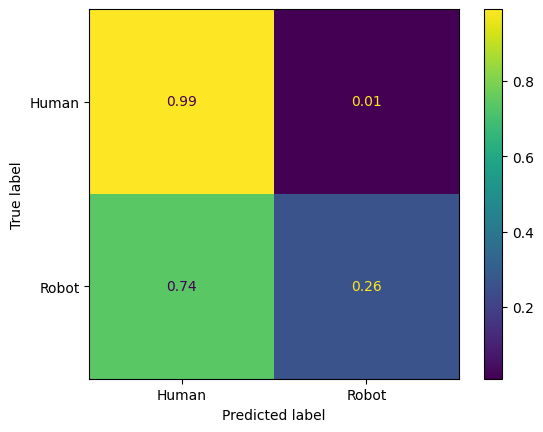

In [32]:
param_grid_lr_scale = {
    'C': [0.1, 1, 10, 20, 30],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'max_iter': [100, 200, 300, 400]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('grid_search', GridSearchCV(LogisticRegression(random_state=42), param_grid_lr_scale, cv=5, n_jobs=-1))
])

pipeline.fit(X_train, y_train)

print(pipeline['grid_search'].best_params_)
print("\n")

lgr_clf_scale = pipeline['grid_search'].best_estimator_

lgr_clf_scale.fit(X_train, y_train)

y_pred_lgr_scale = lgr_clf_scale.predict(X_test)

print("\nAccuracy: {:.2f}".format(((accuracy_score(y_test, y_pred_lgr_scale)) * 100)) + "%")
print(classification_report(y_test, y_pred_lgr_scale))
print("\n")

cm = np.round(confusion_matrix(y_test, y_pred_lgr_scale, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [33]:
filename8 = './main_models2/lgr_clf_scale.sav'
pickle.dump(lgr_clf_scale, open(filename8, 'wb'))

##### 2.3 Zonder scaling

---


{'C': 0.1, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}



Accuracy: 94.75%


              precision    recall  f1-score   support

           0       0.99      0.95      0.97     10337
           1       0.81      0.95      0.87      2460

    accuracy                           0.95     12797
   macro avg       0.90      0.95      0.92     12797
weighted avg       0.95      0.95      0.95     12797



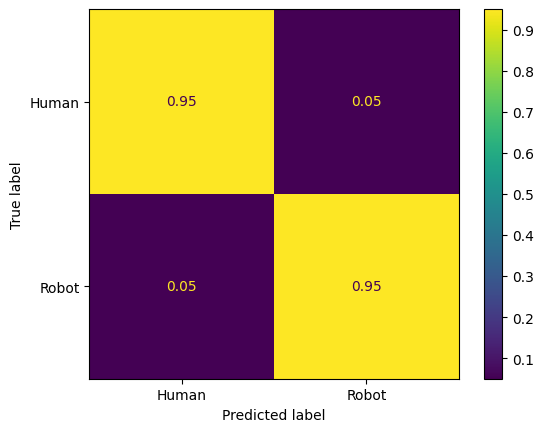

In [34]:
gs_no_scale = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr_scale, cv=5, n_jobs=-1)

gs_no_scale.fit(X_train, y_train)

print(gs_no_scale.best_params_)
print("\n")

lgr_clf_no_scale = gs_no_scale.best_estimator_

lgr_clf_no_scale.fit(X_train, y_train)

y_pred_lgr_no_scale = lgr_clf_no_scale.predict(X_test)


print("\nAccuracy: {:.2f}".format(((accuracy_score(y_test, y_pred_lgr_no_scale)) * 100)) + "%")
print("\n")
print(classification_report(y_test, y_pred_lgr_no_scale))

cm = np.round(confusion_matrix(y_test, y_pred_lgr_no_scale, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [35]:
filename9 = './main_models2/lgr_clf_no_scale.sav'
pickle.dump(lgr_clf_no_scale, open(filename9, 'wb'))

##### 2.4 Test op 5% achtergehouden data

**Scale**

45.58% Human | 54.42% Robot

Accuracy: 69.18%

Classification report:
```
               precision    recall  f1-score   support

           0       0.99      0.60      0.74      2531
           1       0.45      0.97      0.61       837

    accuracy                           0.69      3368
   macro avg       0.72      0.79      0.68      3368
weighted avg       0.85      0.69      0.71      3368
```

Confusion matrix:
```
[[0.6  0.4 ]
 [0.03 0.97]]
```

**No scale**

70.96% Human | 29.04% Robot

Accuracy: 93.20%

Classification report:
```
               precision    recall  f1-score   support

           0       0.98      0.93      0.95      2531
           1       0.81      0.95      0.87       837

    accuracy                           0.93      3368
   macro avg       0.90      0.94      0.91      3368
weighted avg       0.94      0.93      0.93      3368
```

Confusion matrix:
```
[[0.93 0.07]
 [0.05 0.95]]
```

### 3. LinearSVC

##### 3.1 Parameters

---

C:

- Voordelen: regelt de mate van reguliere term in het model. Een hogere waarde geeft minder regulatie, waardoor het model meer nadruk legt op het correct classificeren van elk trainingsvoorbeeld. Dit kan nuttig zijn wanneer er minder ruis aanwezig is in de gegevens en het doel is om de trainingsvoorbeelden nauwkeurig te classificeren.
- Nadelen: te hoog wordt ingesteld, kan het model gevoeliger worden voor ruis in de gegevens en kan overfitting optreden. C waarde kiezen --> goed evenwicht te bereiken tussen het minimaliseren van de fout op trainingsgegevens en het generaliseren naar nieuwe, ongeziene gegevens.

max_iter:

- Voordelen: bepaalt het maximale aantal iteraties dat het model zal doorlopen bij het optimaliseren van de gewichten. Het beïnvloedt de trainingstijd en de nauwkeurigheid van het model.
- Nadelen: Een te laag aantal 'max_iter'-waarden kan ertoe leiden dat het model niet convergent is en geen optimaal resultaat behaalt. Aan de andere kant kan een te hoog aantal iteraties de trainingsduur verlengen zonder significant betere resultaten te behalen

##### 3.2 Met scaling

---

{'C': 30, 'max_iter': 3000}



Accuracy: 85.90%


              precision    recall  f1-score   support

           0       0.97      0.85      0.91     10337
           1       0.59      0.90      0.71      2460

    accuracy                           0.86     12797
   macro avg       0.78      0.87      0.81     12797
weighted avg       0.90      0.86      0.87     12797



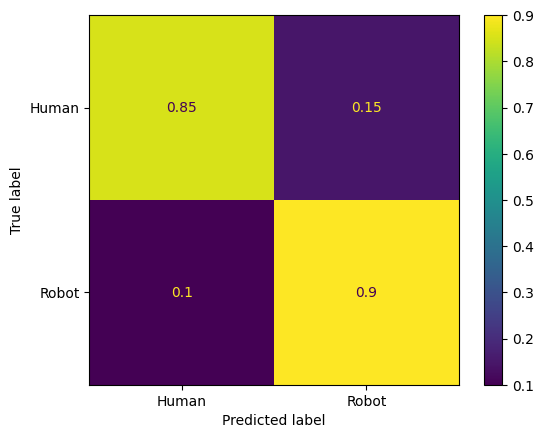

In [36]:
param_grid_lsvc = {
    'C': [0.1, 1, 20, 25, 30, 35],
    'max_iter': [1000, 2000, 3000, 3500]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('grid_search', GridSearchCV(LinearSVC(random_state=42), param_grid_lsvc, n_jobs=-1, cv=5))
])

pipeline.fit(X_train, y_train)

print(pipeline['grid_search'].best_params_)
print("\n")

lsvc_clf_scale = pipeline['grid_search'].best_estimator_

lsvc_clf_scale.fit(X_train, y_train)

y_pred_lsvc_scale = lsvc_clf_scale.predict(X_test)

print("\nAccuracy: {:.2f}".format(((accuracy_score(y_test, y_pred_lsvc_scale)) * 100)) + "%")
print("\n")
print(classification_report(y_test, y_pred_lsvc_scale))

cm = np.round(confusion_matrix(y_test, y_pred_lsvc_scale, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [37]:
filename10 = './main_models2/lsvc_clf_scale.sav'
pickle.dump(lsvc_clf_scale, open(filename10, 'wb'))

##### 3.3 Zonder scaling

---

{'C': 0.1, 'max_iter': 3000}



Accuracy: 89.18%


              precision    recall  f1-score   support

           0       0.92      0.95      0.93     10337
           1       0.76      0.64      0.69      2460

    accuracy                           0.89     12797
   macro avg       0.84      0.79      0.81     12797
weighted avg       0.89      0.89      0.89     12797



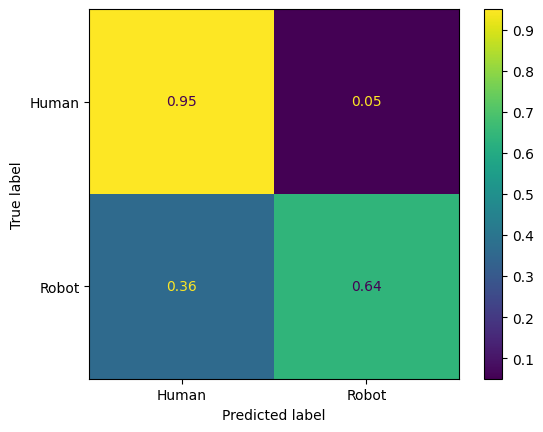

In [38]:
lsvc_gs_no_scale = GridSearchCV(LinearSVC(random_state=42), param_grid_lsvc, n_jobs=-1, cv=5)

lsvc_gs_no_scale.fit(X_train, y_train)

print(lsvc_gs_no_scale.best_params_)
print("\n")

lsvc_no_scale = lsvc_gs_no_scale.best_estimator_

lsvc_no_scale.fit(X_train, y_train)

lsvc_y_pred_no_scale = lsvc_no_scale.predict(X_test)

print("\nAccuracy: {:.2f}".format(((accuracy_score(y_test, lsvc_y_pred_no_scale)) * 100)) + "%")
print("\n")
print(classification_report(y_test, lsvc_y_pred_no_scale))

cm = np.round(confusion_matrix(y_test, lsvc_y_pred_no_scale, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [39]:
filename11 = './main_models2/lsvc_clf_no_scale.sav'
pickle.dump(lsvc_no_scale, open(filename11, 'wb'))

##### 3.4 Test op 5% achtergehouden data

**Scale**

63.36% Human | 36.64% Robot

Accuracy: 68.26%

Classification report:
```
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      2531
           1       0.41      0.60      0.48       837

    accuracy                           0.68      3368
   macro avg       0.62      0.65      0.63      3368
weighted avg       0.73      0.68      0.70      3368
```

Confusion matrix:
```
[[0.71 0.29]
 [0.4  0.6 ]]
```

**No scale**

75.53% Human | 24.47% Robot

Accuracy: 83.22%

Classification report:
```
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      2531
           1       0.67      0.65      0.66       837

    accuracy                           0.83      3368
   macro avg       0.78      0.77      0.77      3368
weighted avg       0.83      0.83      0.83      3368
```

Confusion matrix:
```
[[0.89 0.11]
 [0.35 0.65]]
```